<a href="https://colab.research.google.com/github/aaron-v19/mlprojects/blob/main/Beatrice_ttm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installation

In [2]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

fatal: destination path 'tsfm' already exists and is not an empty directory.


In [3]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [4]:
# Do ls
! ls

build	 Makefile   pyproject.toml  scripts   tests	   tsfm_public		 wiki.md
LICENSE  notebooks  README.md	    services  tsfmhfdemos  tsfm_public.egg-info


In [5]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tsfm_public: filename=tsfm_public-0.2.19.dev7+g397c895-py3-none-any.whl size=2338172 sha256=cb496dd115c2a59e3db4518daf5c317ec0727a3d49e9dbafcd3e3b0c7022017e
  Stored in directory: /tmp/pip-ephem-wheel-cache-9h574p8s/wheels/b0/e9/d5/46ac6e5f659a03cfc8e396b992ac1b7e0c0bd1e34c7f5fe8e4
Successfully built tsfm_public
  Attempting uninstall: tsfm_public
    Found existing installation: tsfm_public 0.2.19.dev7+g397c895
    Uninstalling tsfm_public-0.2.19.dev7+g397c895:
      Successfully uninstalled tsfm_public-0.2.19.dev7+g397c895


Import Libraries

In [12]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd




# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

In [14]:
# First Party
from tsfm_public import count_parameters

from tsfm_public.toolkit.visualization import plot_predictions as plot_preds

#Important Arguments

In [16]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "beatrice"
DATA_ROOT_PATH = "/content/drive/MyDrive/Windmill project/Beatrice.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

#Get data

In [24]:
# Load the data file and see the columns
data = pd.read_csv(DATA_ROOT_PATH,parse_dates=['time'])
data

,Unnamed: 0,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power_of_SWT-7.0-154,Turn_off,Power
0,0,01-01-1980 00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800,1,378.95800
1,1,01-01-1980 01:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520,1,390.87520
2,2,01-01-1980 02:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732,1,379.56732
3,3,01-01-1980 03:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005,1,376.18005
4,4,01-01-1980 04:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446,1,406.82446
...,...,...,...,...,...,...,...,...,...,...,...
350635,350635,31-12-2019 19:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489,1,176.63489
350636,350636,31-12-2019 20:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825,1,156.59825
350637,350637,31-12-2019 21:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127,1,162.77127
350638,350638,31-12-2019 22:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679,1,140.61679


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 350640 non-null  int64  
 1   time                       350640 non-null  object 
 2   u100                       350640 non-null  float64
 3   v100                       350640 non-null  float64
 4   fsr                        350640 non-null  float64
 5   Windspeed                  350640 non-null  float64
 6   Scaled_Windspeed_(at_90m)  350640 non-null  float64
 7   Wind_Direction             350640 non-null  float64
 8   Power_of_SWT-7.0-154       350640 non-null  float64
 9   Turn_off                   350640 non-null  int64  
 10  Power                      350640 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 29.4+ MB


<Axes: xlabel='time'>

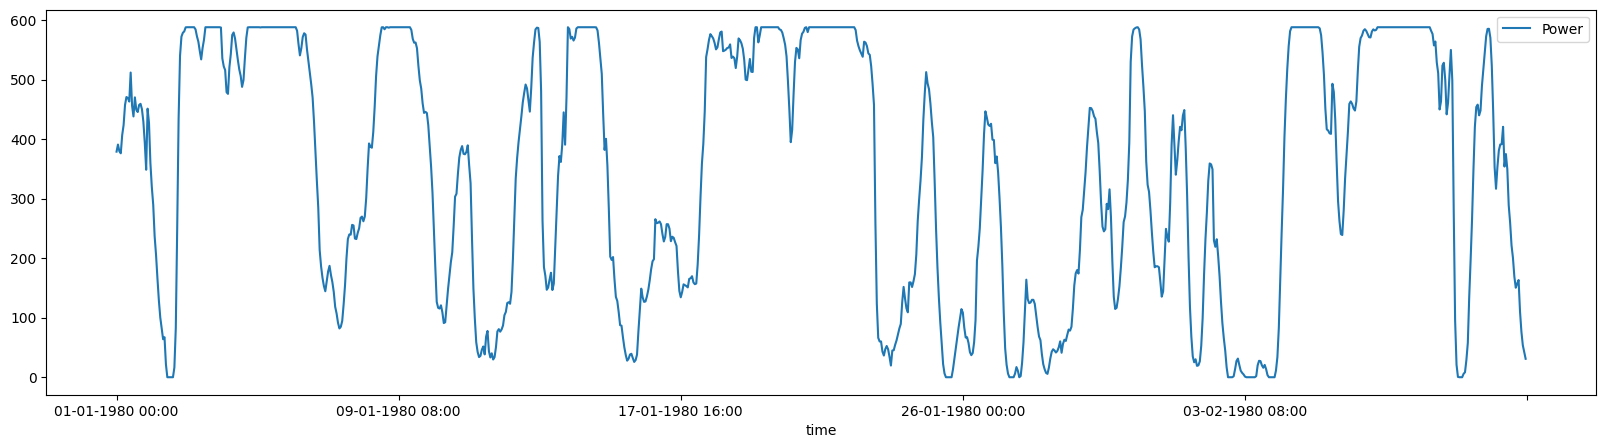

In [27]:
data.iloc[:1000].plot(x="time", y="Power", figsize=(20,5))

#Initial Cleaning


So we see that there is no power generated when Turn_off=0 and also Power_of_SWT-7.0-154 is same as Power.

Then we can drop following Columns and row without affecting our results

1. Unnamed:0
2. Power_of_SWT-7.0-154
3. Turn_off (After removing rows containing 0 as value)

In [28]:
# Drop Row containg Turn_off value=0
data=data[data['Turn_off'] !=0]
data['Turn_off'].value_counts()

,count
Turn_off,
1,350388


In [ ]:
# Drop Columns
cols_to_drop=['Power_of_SWT-7.0-154','Unnamed: 0','Turn_off']
data.drop(columns=cols_to_drop,inplace=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350388 entries, 0 to 350639
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       350388 non-null  object 
 1   u100                       350388 non-null  float64
 2   v100                       350388 non-null  float64
 3   fsr                        350388 non-null  float64
 4   Windspeed                  350388 non-null  float64
 5   Scaled_Windspeed_(at_90m)  350388 non-null  float64
 6   Wind_Direction             350388 non-null  float64
 7   Power                      350388 non-null  float64
dtypes: float64(7), object(1)
memory usage: 24.1+ MB


# Data Processing Pipeline

In [ ]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = DATA_ROOT_PATH
timestamp_column = "time"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
                "train": [0, 12 * 30 * 24 * 4],
                "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
                "test": [
                    12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
                    12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
                ],
            }
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")